# Class Workbook

## In class activity

In [1]:
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
from plotnine import *
# import statsmodels.formula.api as sm
# from ISLP import load_data
# from ISLP.models import (ModelSpec as MS,
#                         summarize ,
#                         poly)
from sklearn.base import clone
from functools import partial
from ISLP.models import sklearn_sm
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.metrics import mean_squared_error


### Ames House Data

In [2]:
ames_raw=pd.read_csv("ames_raw.csv")

ames_raw['SalePricelog'] = np.log(ames_raw['SalePrice'])

Let's revisit the AmesHousing data.  As we did in the previous class, I will split the data into before 2008 and after.  The data up to 2008 will be the training data and after 2008 will be the testing data.

In [3]:
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

* For the regression model fit, use bootstrap to compare the standard error estimates to the model based estimates.

Your code:

In [4]:
ames_raw_2008

pd.set_option('display.max_rows', None)
print(ames_raw_2008.isnull().sum())

# The follwing variables have lots of NA
# Lot Frontage        213
# Alley              1235
# Fireplace Qu        622
# Pool QC            1309
# Fence              1070
# Misc Feature       1280

pd.reset_option('display.max_rows')

Order                 0
PID                   0
MS SubClass           0
MS Zoning             0
Lot Frontage        213
Lot Area              0
Street                0
Alley              1235
Lot Shape             0
Land Contour          0
Utilities             0
Lot Config            0
Land Slope            0
Neighborhood          0
Condition 1           0
Condition 2           0
Bldg Type             0
House Style           0
Overall Qual          0
Overall Cond          0
Year Built            0
Year Remod/Add        0
Roof Style            0
Roof Matl             0
Exterior 1st          0
Exterior 2nd          0
Mas Vnr Type         12
Mas Vnr Area         12
Exter Qual            0
Exter Cond            0
Foundation            0
Bsmt Qual            33
Bsmt Cond            33
Bsmt Exposure        35
BsmtFin Type 1       33
BsmtFin SF 1          0
BsmtFin Type 2       33
BsmtFin SF 2          0
Bsmt Unf SF           0
Total Bsmt SF         0
Heating               0
Heating QC      

In [5]:
pd.reset_option('display.max_rows')

In [6]:
# remove variables with lots of missing variables
columns_to_exclude = ['Lot Frontage', 'Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']
ames_raw_2008_sub = ames_raw_2008.drop(columns=columns_to_exclude)

# remove missing values from the sub data set
ames_raw_2008_sub.dropna(inplace=True)

# check typs of each variable
# ames_raw_2008_sub.dtypes 

# # transform object class to category to create dummy variable using MS class
# object_columns = ames_raw_2008_sub.select_dtypes(include='object').columns
# ames_raw_2008_sub[object_columns] = ames_raw_2008_sub[object_columns].astype('category')

# reset Index prepating for the Bootstrap
# ames_raw_2008_sub.reset_index(drop=True, inplace=True)

In [7]:
# chose predictors from sacatter plots
X = ames_raw_2008_sub[['Year Built', 'Year Remod/Add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Garage Area']]
# formula = "np.log(SalePrice) ~ 1 + Q('Year Built') + Q('Year Remod/Add') + Q('Total Bsmt SF') + Q('1st Flr SF') + Q('2nd Flr SF') + Q('Gr Liv Area') + Q('Full Bath') + Q('TotRms AbvGrd') + Q('Garage Area')"

Y = ames_raw_2008_sub['SalePrice']

lmfit_2008 = sm.OLS(Y, sm.add_constant(X)).fit()

In [8]:
sample_iter = 1000

bootstrap_se = np.ndarray((sample_iter, len(lmfit_2008.params)))

for i in range(sample_iter):
    bs_X = X.sample(frac = 0.5, replace = True)
    bs_Y = Y[bs_X.index]
    
    bs_fit = sm.OLS(bs_Y, sm.add_constant(bs_X)).fit()
    bootstrap_se[i] = bs_fit.bse
    

bootstrap_avg_se = bootstrap_se.mean(axis = 0)

print(f'bootstrap_se = \n{bootstrap_avg_se}')

print(f'model_based_se = \n{lmfit_2008.bse}')  


bootstrap_se = 
[2.04616141e+05 8.95778733e+01 1.18496979e+02 9.75726666e+00
 6.54182912e+01 6.50456612e+01 6.48780275e+01 4.60866145e+03
 1.93789995e+03 1.20308199e+01]
model_based_se = 
const             148064.597632
Year Built            64.537299
Year Remod/Add        85.501132
Total Bsmt SF          6.919141
1st Flr SF            36.670972
2nd Flr SF            36.410293
Gr Liv Area           36.291147
Full Bath           3332.846355
TotRms AbvGrd       1399.804749
Garage Area            8.683395
dtype: float64


Your answer:

~~~
Please write your answer in full sentences.

SE from the Bootstrap method is wider than model based SE. This is reasonable because bootstrap method is more robust than model based estimation.
~~~


* Use cross validation  to decide which model has a good predictive accuracy.  Does the result hold true for the prediction of future data?

Your code:

In [9]:
kf = KFold(n_splits=10, shuffle=True, random_state=123)
# shuffle before deviding data

mse_model1 = []
mse_model2 = []

for train_index, validation_index in kf.split(ames_raw_2008_sub):
    train_data, validation_data = ames_raw_2008_sub.iloc[train_index], ames_raw_2008_sub.iloc[validation_index]
    
    X_train = train_data[['Year Built', 'Year Remod/Add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Garage Area']]
    Y_train = Y[X_train.index]

    X_val = validation_data[['Year Built', 'Year Remod/Add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Garage Area']]

    # Model 1　(The previous model I selected above)
    model1 = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
    predictions1 = model1.predict(sm.add_constant(X_val))
    # predictions1= predictions1.fillna(predictions1.mean())
    mse_model1.append(mean_squared_error(validation_data['SalePrice'], predictions1))
    
    # Model 2 (Included "Overall Qual" on the model 1)
    X2_train = train_data[['Overall Qual', 'Year Built', 'Year Remod/Add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Garage Area']]
    
    X2_val = validation_data[['Overall Qual', 'Year Built', 'Year Remod/Add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Garage Area']]

    model2 = sm.OLS(Y_train, sm.add_constant(X2_train)).fit()
    predictions2 = model2.predict(sm.add_constant(X2_val))
    # predictions2 = predictions2.fillna(predictions2.mean())
    mse_model2.append(mean_squared_error(validation_data['SalePrice'], predictions2))



# Average MSE
avg_mse_model1 = np.mean(mse_model1)
avg_mse_model2 = np.mean(mse_model2)

print(f"Model 1 Average MSE: {avg_mse_model1}")
print(f"Model 2 Average MSE: {avg_mse_model2}")



Model 1 Average MSE: 1939459655.707212
Model 2 Average MSE: 1553774108.840901


Your answer:

~~~
Please write your answer in full sentences.

From the 10-fold cross validation, MSE became smaller after adding variables 'Overall Qual' in the model.   
I created validation data sets through CV methods to expect that we can predict the MSE for the test data set (future data sets), but I think this is not always true.
~~~


* Using `knn.reg` fit KNN regression model.  Use cross validation to decide which K to use.

Your code:

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

def cv_knn(k_range, X, Y, cv_iter):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    k_candidates = k_range
    cv_score = []

    for k in k_candidates:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X_scaled, Y, cv=cv_iter, scoring='neg_mean_squared_error')
        cv_score.append(-scores.mean())
            
    best_k = k_candidates[np.argmin(cv_score)]
    print(f'Best K = {best_k} with CV score = {min(cv_score)}')

    return cv_score

cv_res_knn = cv_knn(range(1, 20), X=X, Y=Y, cv_iter=5)


Best K = 11 with CV score = 1575734522.6829734


Your answer:

~~~
Please write your answer in full sentences.


~~~


* Which model performs better on your training data?  Which model performs better in your future prediction?

Your code:

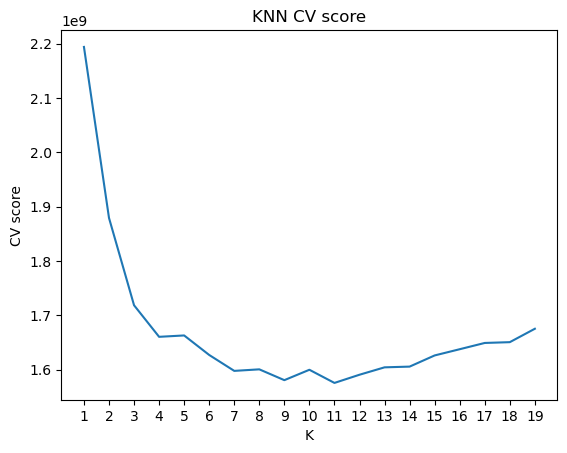

In [11]:
import matplotlib.pyplot as plt
plt.plot(range(1,20), cv_res_knn)
plt.xlabel('K')
plt.ylabel('CV score')
plt.title('KNN CV score')
plt.xticks(range(1,20))
plt.show()

Your answer:

~~~
Please write your answer in full sentences.


~~~

## Problem Set

### Bootstrap

We will now investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We first create an array store with values that will subsequently
be overwritten using the function np.empty(). We then repeatedly create bootstrap samples, and each time we record whether or not the fifth observation is contained in the bootstrap
sample.

We will investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We repeatedly create bootstrap samples, and each time
we record whether or not the fourth observation is contained in the bootstrap sample.

Here is the code to get you going

In [12]:
rng = np.random.default_rng (10)
store = np.empty (10000)
for i in range (10000):
    store[i] = np.sum(rng.choice(100, 100, replace=True) == 4) > 0

np.mean(store)

0.6362

Comment on the results obtained.


Your code:

In [13]:
def bs_prob(n_times):
    population = range(100)
    prob_list = []
    for i in range(n_times) :
        samples = np.random.choice(population, 100, replace = True)
        
        if 4 in samples:
            prob_list.append(1)
        else:
            prob_list.append(0)
    
    return prob_list
        
result = bs_prob(10000)

In [14]:
print(np.mean(result))

0.6383


Your answer:

~~~
Please write your answer in full sentences.

From the Bootstrap method above, the probabiliy of specific obseravation being included is 0.632. This is almost same as the result from mathmatical calculation.
~~~

### CV

We will now perform cross-validation on a simulated data set.
(a) Generate a simulated data set as follows:

In [15]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

In this data set, what is n and what is p? Write out the model
used to generate the data in equation form.


Your code:

Your answer:

~~~
Please write your answer in full sentences.

n = 100 (len(x))
p = 1 (only x)
~~~


(b) Create a scatterplot of X against Y . Comment on what you find.


Your code:

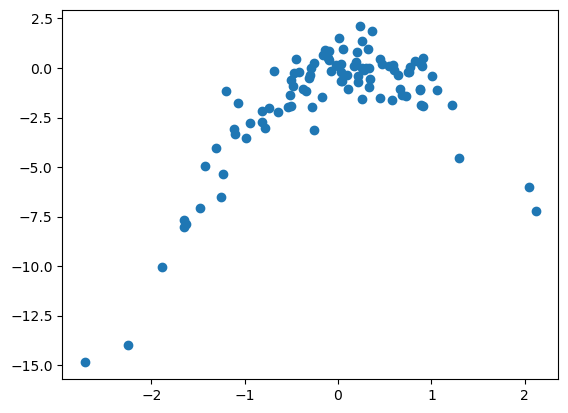

In [16]:
plt.scatter(x, y)
plt.show()

Your answer:

~~~
Please write your answer in full sentences.

This shape seems quadratic.
~~~

(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:

i.   $Y = \beta_0 + \beta_1X + \epsilon$
ii.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon$
iii. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$
iv.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \beta_4X^4 + \epsilon$.

Note you may find it helpful to use the `data.frame()` function
to create a single data set containing both $X$ and $Y$ .


Your code:

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# Define the degrees for the polynomial models
degrees = [1, 2, 3, 4]
rng = np.random.default_rng(123)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)
# For each degree, fit the model and compute the LOOCV error
for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept = False))
    scores = cross_val_score(model, sm.add_constant(x), y, cv=x.shape[0], scoring='neg_mean_squared_error')
    #  cv=x.shape[0] represents k = n (that means LOOCV)
    print(f'LOOCV error for degree {degree}: {-scores.mean()}')

LOOCV error for degree 1: 5.363021199129374
LOOCV error for degree 2: 0.886059885605546
LOOCV error for degree 3: 0.9126899843763812
LOOCV error for degree 4: 0.958589590738793


Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Repeat (c) using another random seed, and report your results.
Are your results the same as what you got in (c)? Why?

Your code:

In [18]:
degrees = [1, 2, 3, 4]
rng = np.random.default_rng(1234)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)
# For each degree, fit the model and compute the LOOCV error
for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept = False))
    scores = cross_val_score(model, sm.add_constant(x), y, cv=x.shape[0], scoring='neg_mean_squared_error')
    #  cv=x.shape[0] represents k = n (that means LOOCV)
    print(f'LOOCV error for degree {degree}: {-scores.mean()}')

LOOCV error for degree 1: 12.953546149037813
LOOCV error for degree 2: 1.1213575716004756
LOOCV error for degree 3: 1.130669835402615
LOOCV error for degree 4: 1.1475232183470074


Your answer:

~~~
Please write your answer in full sentences.

Even though cross validation scores are changed when we use another random seed, but the conclustion that model with degree 2 is the best is same beween them. 
~~~

(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

Your code:

Your answer:

~~~
Please write your answer in full sentences.

As shown in the scatter plot, the quadracic function shows the best score.
~~~


(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?


Your code:

In [19]:
rng = np.random.default_rng(123)
x = rng.normal(size=100).reshape(-1, 1)
y = x.flatten() - 2 * x.flatten()**2 + rng.normal(size=100)
# For each degree, fit the model and compute the LOOCV error
for degree in degrees:
    print(f'Degree = {degree}')
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    model.fit(x, y)
    intercept, coef = model.named_steps['linearregression'].intercept_, model.named_steps['linearregression'].coef_
    
    print(f'intercept = {intercept}')
    print(f'coef = {coef}')

Degree = 1
intercept = -1.4915097467377099
coef = [0.         0.68177198]
Degree = 2
intercept = 0.0352790337096438
coef = [ 0.          1.04294946 -1.9268314 ]
Degree = 3
intercept = 0.040492157308186005
coef = [ 0.          1.11727445 -1.93187021 -0.0334299 ]
Degree = 4
intercept = 0.1020641416208159
coef = [ 0.          1.14506065 -2.11040241 -0.03586033  0.04554276]


Your answer:

~~~
Please write your answer in full sentences.


~~~

### Default 1

In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

(a) Fit a logistic regression model that uses income and balance to predict default.

Your code:

In [20]:
from ISLP import load_data
Default = load_data('Default')

Default['defaultInt'] = (Default['default'] == 'Yes').astype(int)

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set.

Your code:

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Default[['income', 'balance']], Default['defaultInt'], test_size=0.3, random_state=123)

Your answer:

~~~
Please write your answer in full sentences.


~~~

ii. Fit a multiple logistic regression model using only the training observations.

Your code:

In [22]:
model_lr = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print(model_lr.summary())

Optimization terminated successfully.
         Current function value: 0.081061
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             defaultInt   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6997
Method:                           MLE   Df Model:                            2
Date:                Sun, 18 Feb 2024   Pseudo R-squ.:                  0.4484
Time:                        10:00:25   Log-Likelihood:                -567.43
converged:                       True   LL-Null:                       -1028.6
Covariance Type:            nonrobust   LLR p-value:                5.091e-201
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1762      0.491    -22.778      0.000     -12.138     -10.214
income      2.051e-05   5.79

Your answer:

~~~
Please write your answer in full sentences.


~~~


iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.


Your code:

In [23]:
accuracy = np.mean((model_lr.predict(sm.add_constant(X_test)) > 0.5) == y_test)
print(accuracy)

0.9743333333333334


Your answer:

~~~
Please write your answer in full sentences.


~~~


iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

Your code:

In [24]:
print(f'Validation set error is {1 - accuracy}')

Validation set error is 0.025666666666666615


Your answer:

~~~
Please write your answer in full sentences.


~~~


(c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.


Your code:

In [25]:
from sklearn.model_selection import train_test_split

# random_state = 0, 1, 2,
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(Default[['income', 'balance']], Default['defaultInt'], test_size=0.3, random_state = i)
    
    model_lr = sm.Logit(y_train, sm.add_constant(X_train)).fit()
    
    accuracy = np.mean((model_lr.predict(sm.add_constant(X_test)) > 0.5) == y_test)
    
    print(f'accuracy(state{i} is {accuracy}')

Optimization terminated successfully.
         Current function value: 0.076858
         Iterations 10
accuracy(state0 is 0.9726666666666667
Optimization terminated successfully.
         Current function value: 0.078788
         Iterations 10
accuracy(state1 is 0.9753333333333334
Optimization terminated successfully.
         Current function value: 0.082411
         Iterations 10
accuracy(state2 is 0.9763333333333334


Your answer:

~~~
Please write your answer in full sentences.

We got almost same results (accuracy is around 97-98%), but the exact value is different from each other.
~~~


(d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.


Your code:

In [26]:
Default['studentInt'] = (Default['student'] == 'Yes').astype(int)

In [27]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(Default[['studentInt', 'income', 'balance']], Default['defaultInt'], test_size=0.3, random_state = i)
model_lr2 = sm.Logit(y_train2, sm.add_constant(X_train2)).fit()
print(model_lr2.summary())

Optimization terminated successfully.
         Current function value: 0.081915
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             defaultInt   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6996
Method:                           MLE   Df Model:                            3
Date:                Sun, 18 Feb 2024   Pseudo R-squ.:                  0.4794
Time:                        10:00:26   Log-Likelihood:                -573.41
converged:                       True   LL-Null:                       -1101.5
Covariance Type:            nonrobust   LLR p-value:                1.161e-228
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8795      0.572    -19.029      0.000     -12.000      -9.759
studentInt    -0.7184      0

In [28]:
accuracy2 = np.mean((model_lr2.predict(sm.add_constant(X_test2)) > 0.5) == y_test2)
print(f'accuracy for model with student variable is{accuracy2}')

accuracy for model with student variable is0.9763333333333334


Your answer:

~~~
Please write your answer in full sentences.

The accuracy from these two models are almost same.
~~~

### Default 2

We continue to consider the use of a logistic regression model to
predict the probability of default using income and balance on the
Default data set. In particular, we will now compute estimates for the
standard errors of the income and balance logistic regression coefficients
in two different ways: (1) using the bootstrap, and (2) using the
standard formula for computing the standard errors in the sm.GLM()
function. Do not forget to set a random seed before beginning your
analysis.

(a) Using the `summarize()` and `sm.GLM()` functions, determine the
estimated standard errors for the coefficients associated with
income and balance in a multiple logistic regression model that
uses both predictors.
Your code:

In [29]:
from statsmodels.genmod.generalized_linear_model import GLM
model_glm = GLM(y_train, sm.add_constant(X_train), family = sm.families.Binomial()).fit()
print(model_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             defaultInt   No. Observations:                 7000
Model:                            GLM   Df Residuals:                     6997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -576.88
Date:                Sun, 18 Feb 2024   Deviance:                       1153.8
Time:                        10:00:26   Pearson chi2:                 4.82e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1392
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.6174      0.509    -22.830      0.0

In [30]:
# compare SE from Booststrap and model based one
X = Default[['income', 'balance']]
y = Default['defaultInt']

n = 1000
bootstrap_se = np.ndarray((n, len(model_glm.params)))

for i in range(n):
    bs_X = X.sample(frac = 0.5, replace = True)
    bs_Y = y[bs_X.index]
    
    bs_fit = sm.GLM(bs_Y, sm.add_constant(bs_X), family = sm.families.Binomial()).fit()
    bootstrap_se[i] = bs_fit.bse
    

bootstrap_avg_se = bootstrap_se.mean(axis = 0)

print(f'bootstrap_se = \n{bootstrap_avg_se}')

print(f'model_based_se = \n{model_glm.bse}')  

bootstrap_se = 
[6.19730539e-01 7.09470079e-06 3.24046327e-04]
model_based_se = 
const      0.508875
income     0.000006
balance    0.000268
dtype: float64


Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Write a function, `boot_fn()`, that takes as input the Default data
set as well as an index of the observations, and that outputs
the coefficient estimates for income and balance in the multiple
logistic regression model.

Your code:

In [31]:
# I have to debug this function
# def boot_fn(data, num_iterations):
#     bootstrap_se = np.ndarray((num_iterations, len(model_glm.params)))
#     for i in range(num_iterations):
#         # Bootstrap sampling with replacement
#         bootstrap_sample = data.sample(frac=0.5, replace=True)
        
#         X = bootstrap_sample[['income', 'balance']]
#         y = bootstrap_sample['defaultInt']
        
#         X_cons = sm.add_constant(X)
        
#         bs_fit = sm.GLM(y, X_cons, family=sm.families.Binomial())
        
#         # Store coefficients
#         bootstrap_se[i] = bs_fit.bse
    
#     return pd.DataFrame(bootstrap_se)

# # Call the function
# bootstrap_se = boot_fn(Default, 1000)

# bootstrap_avg_se = bootstrap_se.mean()

# print("Mean se estimates for income and balance:")
# print(bootstrap_avg_se)


In [32]:
# boot_fn(Default, index = range(len(Default)), out_params = 'se')

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Following the bootstrap example in the lab, use your `boot_fn()`
function to estimate the standard errors of the logistic regression
coefficients for income and balance.


Your code:

In [33]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Comment on the estimated standard errors obtained using the `sm.GLM()` function and using the bootstrap.

Your answer:

~~~
Please write your answer in full sentences.

SE from bootstrap is wider than that from GLM() function. This is reasonable becauase bootstrap methos is more robust.
~~~

### Boston housing data set

We will now consider the Boston housing data set, from the ISLR library.

In [34]:
Boston = load_data("Boston")

(a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate $\hat{\mu}$.

Your code:

In [35]:
Boston.medv.mean()

22.532806324110677

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Provide an estimate of the standard error of $\hat{\mu}$. Interpret this result.
Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.

Your code:

In [36]:
medv_se = Boston.medv.std()/np.sqrt(len(Boston.medv))
medv_se

0.4088611474975351

Your answer:

~~~
Please write your answer in full sentences.


~~~


(c) Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does this compare to your answer from (b)?

Your code:

In [37]:
n = 1000 
bootstrap_means = []  

for i in range(n):
    sample = Boston.medv.sample(n=len(Boston.medv), replace=True)
    
    bootstrap_means.append(sample.mean())

bootstrap_se = np.std(bootstrap_means)

print(bootstrap_se)

0.42063030258794354


Your answer:

~~~
Please write your answer in full sentences.

The se of medv from bootstrap is a bit wider than that from (b).
~~~

(d) Based on your bootstrap estimate from (c), provide a 95 % confidence
interval for the mean of medv. Compare it to the results
obtained by using `Boston['medv'].std()` and the two standard
error rule (3.9).
Hint: You can approximate a 95% confidence interval using the formula $[\hat{\mu} − 2SE(\hat{\mu}), \hat{\mu} + 2SE(\hat{\mu})]$.

Your code:

In [38]:
# Calculate the mean of 'medv' using bootstrap estimate
bootstrap_mean = np.mean(bootstrap_means)

# Calculate the 95% confidence interval
lower_bound = bootstrap_mean - 2 * bootstrap_se
upper_bound = bootstrap_mean + 2 * bootstrap_se

print("95% Confidence Interval (Bootstrap): [{:.2f}, {:.2f}]".format(lower_bound, upper_bound))

# Calculate standard deviation of 'medv' using the entire dataset
std_medv = Boston['medv'].std()

# Calculate 95% confidence interval using the two standard error rule
lower_bound_2se = Boston.medv.mean() - 2 * medv_se
upper_bound_2se = Boston.medv.mean() + 2 * medv_se

print("95% Confidence Interval (Two Standard Error Rule): [{:.2f}, {:.2f}]".format(lower_bound_2se, upper_bound_2se))

95% Confidence Interval (Bootstrap): [21.69, 23.37]
95% Confidence Interval (Two Standard Error Rule): [21.72, 23.35]


Your answer:

~~~
Please write your answer in full sentences.

95% CI from bootstrap is a bit wider than that from the formula above.
~~~


(e) Based on this data set, provide an estimate, $\hat{\mu}_{med}$, for the median value of medv in the population.

Your code:

In [39]:
Boston['medv'].median()

21.2

Your answer:

~~~
Please write your answer in full sentences.


~~~


(f) We now would like to estimate the standard error of $\hat{\mu}_{med}$. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.

Your code:

In [40]:
n = 1000 
bootstrap_medians = []  

for i in range(n):
    sample = Boston.medv.sample(n=len(Boston.medv), replace=True)
    
    bootstrap_medians.append(sample.median())

bootstrap_med_se = np.std(bootstrap_medians)

print(bootstrap_med_se)

0.3889785308985571


Your answer:

~~~
Please write your answer in full sentences.


~~~



(g) Based on this data set, provide an estimate for the tenth percentile
of medv in Boston census tracts. Call this quantity $\hat{\mu}_{0.1}$.
(You can use the `np.percentile()` function.)

Your code:

In [41]:
np.percentile(Boston['medv'], [10])

array([12.75])

Your answer:

~~~
Please write your answer in full sentences.


~~~


(h) Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$. Comment on your findings.

Your code:

In [42]:
np.percentile(bootstrap_medians, [10])

array([20.6])

Your answer:

~~~
Please write your answer in full sentences.


~~~

## Additional Material

### Cross Validation for Predictive Modeling Platforms in Python

#### scikit-learn

Using platforms like scikit-learn is helpful for things such as cross validation.
There are variants of CV implemented to be used off the shelf
https://scikit-learn.org/stable/modules/cross_validation.html

There are many metrics you can choose from
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [43]:
ames_raw_comp=ames_raw.loc[:,["SalePrice","Gr Liv Area","Lot Area","Total Bsmt SF"]].dropna()
X=ames_raw_comp.loc[:,["Gr Liv Area","Lot Area","Total Bsmt SF"]]
y=ames_raw_comp.loc[:,"SalePrice"]
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import svm
from sklearn.linear_model import LinearRegression
clf =  LinearRegression()
## One metric
scores = cross_val_score(clf, X, y, cv=5,scoring="r2")
## Multiple metrics
scoring = ['r2', 'max_error']
scores = cross_validate(clf, X, y, scoring=scoring)

#### PySpark

[Apache Spark](https://spark.apache.org/docs/3.1.3/api/python/index.html) is a popular large data handling platform.  Over the years, they built Machine Learning capabilities in MLlib.

In [44]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import tempfile

In [45]:
spark = SparkSession.builder.appName("CV_test").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/18 10:00:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [46]:
dataset = spark.createDataFrame(
    [(Vectors.dense([0.0]), 0.0),
     (Vectors.dense([0.4]), 1.0),
     (Vectors.dense([0.5]), 0.0),
     (Vectors.dense([0.6]), 1.0),
     (Vectors.dense([1.0]), 1.0)] * 10,
    ["features", "label"])
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=2)
cvModel = cv.fit(dataset)
cvModel.getNumFolds()
cvModel.avgMetrics[0]
evaluator.evaluate(cvModel.transform(dataset))

24/02/18 10:00:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=34911Kb max_used=34930Kb free=96161Kb
 bounds [0x00000001091e0000, 0x000000010b430000, 0x00000001111e0000]
 total_blobs=13607 nmethods=12492 adapters=1027
 compilation: disabled (not enough contiguous free space left)


0.8333333333333333

In [47]:
spark.stop()

#### Resampling  using h2o

On H2O cross validation is embedded in the function calling so you don't need to worry about learning a new wrapper on top of your estimator.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html

In [48]:
#pip install requests
#pip install tabulate
#pip uninstall h2o
#pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
# load packages and data
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

##### Starting H2O

To use H2O you need to instantiate it.

In [49]:
# nthreads specifies number of threads. -1 means use all the CPU cores.
# max_mem_size specifies the maximum amount of RAM to use.
localH2O= h2o.init(nthreads = -1, max_mem_size="4g")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_401"; Java(TM) SE Runtime Environment (build 1.8.0_401-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.401-b10, mixed mode)
  Starting server from /Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/tmpdmwr49__
  JVM stdout: /var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/tmpdmwr49__/h2o_yutatsukumo_started_from_python.out
  JVM stderr: /var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/tmpdmwr49__/h2o_yutatsukumo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,H2O_from_python_yutatsukumo_1bk15i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.541 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


##### CV with  H2O

In [50]:
# Import the prostate dataset
prostate = h2o.import_file("http://s3.amazonaws.com/h2o-public-test-data/smalldata/prostate/prostate.csv.zip")

# Set the predictor names and the response column name
response = "CAPSULE"
predictors = prostate.names[3:8]

# Convert the response column to a factor
prostate['CAPSULE'] = prostate['CAPSULE'].asfactor()

# Train a GBM model setting nfolds to 5
prostate_gbm = H2OGeneralizedLinearEstimator(nfolds = 5, seed = 1)
prostate_gbm.train(x=predictors, y=response, training_frame=prostate)

# AUC of cross-validated holdout predictions
prostate_gbm.auc(xval=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


0.7790697716207187

##### Shut down H2O

In [51]:
h2o.cluster().shutdown(prompt =False)

H2O session _sid_a53c closed.
